# Microsoft Movie Studios Business Plan

## Overview

## Business Problem

Microsoft sees all the big companies creating original video content and they want to get in on the fun. They have decided to create a new movie studio, but they don’t know anything about creating movies. You are charged with exploring what types of films are currently doing the best at the box office. You must then translate those findings into actionable insights that the head of Microsoft's new movie studio can use to help decide what type of films to create.

Movie production has significant up-front costs that will require internal stakeholder support to adequately fund new projects. Further, it will be important to generate engagement with Microsoft's titles both to maximize return on investment and to legitimize Microsoft as a content producer in the future. Therefore, this analysis aims to generate recommendations on how best to deploy the content production budget. 

We will use data from IMDB, The Numbers and The Movie Database to determine answers to the following questions:

- What genres of movie are likely to optimize return on investment?

- What is the relationship between movie budget and expected gross revenue? 

- What season/month should we target releases in order to optimize our return on investment?





## Data Understanding

For this analysis, we will utilize a database from IMDB, and two datasets from The Numbers.com and The Movie Database. The IMDB database contains robust information for each title--most notably the title, release date and relevant genres. The dataset from TheNumbers.com will primarily be used for return on investment data, including worldwide gross revenue and movie production budget. The Movie Database contains a proprietary popularity score which is calculated based on a number of factors to measure engagement. Documentation for TMDB's popularity score can be found [here.](https://developers.themoviedb.org/3/getting-started/popularity).

In [2]:
# import necessary packages
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import zipfile
import numpy as np
%matplotlib inline

**The IMDB** dataset includes information on movies spanning nearly a century. Given the changing appetites over time, we elect to limit our dataset to movies released in 2010 or later.

In [3]:
# Extract IMDb SQL .db file
with zipfile.ZipFile('./data/im.db.zip') as zipObj:
    # Extract all contents of .zip file into current directory
    zipObj.extractall(path='./data/')
    
# Create connection to IMDb DB
conn = sqlite3.connect('./data/im.db')

In [4]:
# CLEAN UP SQL QUERY

In [5]:
imdbq = """
SELECT
    movie_id,
    primary_title,
    start_year,
    genres
    --,
   -- movie_ratings.averagerating,
   -- movie_ratings.numvotes
    
FROM
    movie_basics
    -- JOIN
      --  movie_ratings
          --  USING(movie_id)
 WHERE
    start_year >= 2010 AND
    start_year <= 2022
    
GROUP BY
    movie_basics.movie_id
;
"""
imdbq_df = pd.read_sql(imdbq, conn)

In [6]:
conn.close()

In [7]:
print(imdbq_df.shape) 
imdbq_df.head(3)

(146133, 4)


,movie_id,primary_title,start_year,genres
0,tt0063540,Sunghursh,2013,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,2019,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,2018,Drama


**The Numbers** contains budget, revenue and release date data for 5782 movies

In [8]:
df_budget = pd.read_csv('./data/tn.movie_budgets.csv.gz', index_col=0)
print(df_budget.shape)
df_budget.head(3)

(5782, 5)


,release_date,movie,production_budget,domestic_gross,worldwide_gross
id,,,,,
1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"


**The Movie Database** contains genre, release date, title and popularity score data for 26517 movies.


In [9]:
df_movies = pd.read_csv('./data/tmdb.movies.csv.gz', index_col=0)
print(df_movies.shape)
df_movies.head(3)


(26517, 9)


,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368


## Data Preparation

Our goal was to combine IMDB's expansive list of movies with TMDB's popularity score and budget data from The Numbers.

### Data Cleaning

#### The Movie Database

We checked TMD's data for instances where both title and release date were duplicated, and dropped those rows. Based on the other data in the table we did not have an easy way to sort out which of the duplicated records was accurate. Since the dropped data was a small subset, the impact on our overall analysis should be minimal.

There were also instances where title was duplicated but original title was not--primarily in movies that were translated to another language. To avoid duplicating records, we dropped the records with duplicated titles as well.

In [10]:
df_movies[['original_title', 'release_date']].duplicated().sum()

1026

In [11]:
df_movies.drop_duplicates(subset=['original_title', 'release_date'], inplace=True)

In [12]:
# May drop this, think it's ok

df_movies.drop(df_movies[df_movies['genre_ids'] == '[]'].index, inplace=True)

In [13]:
df_movies['title'].duplicated().sum()

686

In [14]:
# examine instances where 'title' is duplicated but 'original_title' is not
df_duplicated_titles = df_movies[df_movies['original_title'] != df_movies['title']]
df_duplicated_titles.head(10)


,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
14,"[27, 80]",41439,en,Saw 3D,20.370,2010-10-28,Saw: The Final Chapter,6.0,1488
49,"[10749, 18]",61979,es,Tres metros sobre el cielo,13.721,2010-12-20,Three Steps Above Heaven,7.5,960
67,"[16, 12, 14, 10751]",42949,en,Arthur 3: la guerre des deux mondes,12.679,2010-08-22,Arthur 3: The War of the Two Worlds,5.6,865
70,"[80, 18, 9648, 10749]",25376,es,El secreto de sus ojos,12.531,2010-04-16,The Secret in Their Eyes,7.9,1141
75,[16],28874,ja,サマーウォーズ,12.275,2010-10-13,Summer Wars,7.5,447
79,"[28, 53, 80, 9648]",33613,sv,Luftslottet som sprängdes,12.235,2010-10-29,The Girl Who Kicked the Hornet's Nest,7.0,705
84,"[12, 14, 16, 878]",37933,ja,ゲド戦記,12.005,2010-08-13,Tales from Earthsea,6.6,502
87,"[18, 28, 53, 80, 9648]",24253,sv,Flickan som lekte med elden,11.655,2010-07-09,The Girl Who Played with Fire,7.0,881
98,"[14, 12, 28, 9648]",35552,fr,Les Aventures extraordinaires d'Adèle Blanc-Sec,11.221,2010-04-14,The Extraordinary Adventures of Adèle Blanc-Sec,6.0,671
103,"[28, 18, 36]",11645,ja,乱,10.885,1985-09-26,Ran,8.1,600


In [15]:
df_movies.drop_duplicates(subset='original_title', inplace=True)

#### The Numbers

Description

In [16]:
# Converted release date to a date/time format.

df_budget['release_date'] = pd.to_datetime(df_budget['release_date'])

In [17]:
# Created release year and release month columns, and converted values to integers.

df_budget['release_year'] = df_budget['release_date'].dt.strftime("%Y%m%d").str[:4].astype(int)
df_budget['release_month'] = df_budget['release_date'].dt.strftime("%Y%m%d").str[4:6].astype(int)
df_budget.head(3)

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,release_month
id,,,,,,,
1,2009-12-18,Avatar,"$425,000,000","$760,507,625","$2,776,345,279",2009,12
2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",2011,5
3,2019-06-07,Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350",2019,6


In [18]:
# Removed punctuation from production budget and converted the column values to integers.

df_budget['production_budget'] = df_budget['production_budget'].str.replace(',','')
df_budget['production_budget'] = df_budget['production_budget'].str.replace('$', '')
df_budget['production_budget'] = df_budget['production_budget'].astype(int)

In [19]:
# Removed punctuation from worldwide gross and converted the column values to integers.

df_budget['worldwide_gross'] = df_budget['worldwide_gross'].str.replace(',','')
df_budget['worldwide_gross'] = df_budget['worldwide_gross'].str.replace('$', '')
df_budget['worldwide_gross'] = df_budget['worldwide_gross'].astype(int)

In [20]:
df_budget['movie'].duplicated().sum()

84

In [21]:
# Drop records where movie name is duplicated, and drop unused "domestic_gross" column.

df_budget = df_budget.drop_duplicates(subset='movie')

df_budget = df_budget.drop('domestic_gross', axis=1)

In [22]:
# Add return on investment column equal to worldwide_gross minus production budget.

df_budget['return_on_investment'] = df_budget['worldwide_gross'] - df_budget['production_budget']
df_budget.head(3)

,release_date,movie,production_budget,worldwide_gross,release_year,release_month,return_on_investment
id,,,,,,,
1,2009-12-18,Avatar,425000000,2776345279,2009,12,2351345279
2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,1045663875,2011,5,635063875
3,2019-06-07,Dark Phoenix,350000000,149762350,2019,6,-200237650


#### IMDB

Data contains 2,072 records where primary title AND start year are duplicated, which is ~1.4% of the dataset. We will drop these records as we have no easy way to correlate them with the other data sets, and they comprise an insignificant portion of the overall population.

In [23]:
# Drop rows where primary title and start year are duplicated.

imdbq_df.duplicated(['primary_title', 'start_year']).value_counts()

False    144061
True       2072
dtype: int64

In [24]:
# Drop rows where primary title and start year are duplicated.

imdbq_df = imdbq_df.drop_duplicates(subset=['primary_title', 'start_year'])
imdbq_df.shape

(144061, 4)

In [25]:
# Convert genres column from a single string into a list of strings.

imdbq_df['genres'] = imdbq_df['genres'].str.split(",")

In [26]:
imdbq_df.head(3)

,movie_id,primary_title,start_year,genres
0,tt0063540,Sunghursh,2013,"[Action, Crime, Drama]"
1,tt0066787,One Day Before the Rainy Season,2019,"[Biography, Drama]"
2,tt0069049,The Other Side of the Wind,2018,[Drama]


### Merging Datasets

In [27]:
# inner merge imdb data with tmdb budget data on movie name & year

imdb_inner = imdbq_df.merge(df_budget, how='inner', left_on=['primary_title', 'start_year'], right_on=['movie', 'release_year'])

In [28]:
imdb_inner.shape

(1468, 11)

In [29]:
imdb_inner.head(3)

,movie_id,primary_title,start_year,genres,release_date,movie,production_budget,worldwide_gross,release_year,release_month,return_on_investment
0,tt0249516,Foodfight!,2012,"[Action, Animation, Comedy]",2012-12-31,Foodfight!,45000000,73706,2012,12,-44926294
1,tt0359950,The Secret Life of Walter Mitty,2013,"[Adventure, Comedy, Drama]",2013-12-25,The Secret Life of Walter Mitty,91000000,187861183,2013,12,96861183
2,tt0365907,A Walk Among the Tombstones,2014,"[Action, Crime, Drama]",2014-09-19,A Walk Among the Tombstones,28000000,62108587,2014,9,34108587


### Feature Engineering

Need a column in our IMDB dataframe to represent the delta between worldwide gross revenue and production budget. Added this column below as 'profit'.

In [30]:
imdb_inner['return_on_investment'] = imdb_inner['worldwide_gross'] - imdb_inner['production_budget']

In [31]:
imdb_inner.head()

,movie_id,primary_title,start_year,genres,release_date,movie,production_budget,worldwide_gross,release_year,release_month,return_on_investment
0,tt0249516,Foodfight!,2012,"[Action, Animation, Comedy]",2012-12-31,Foodfight!,45000000,73706,2012,12,-44926294
1,tt0359950,The Secret Life of Walter Mitty,2013,"[Adventure, Comedy, Drama]",2013-12-25,The Secret Life of Walter Mitty,91000000,187861183,2013,12,96861183
2,tt0365907,A Walk Among the Tombstones,2014,"[Action, Crime, Drama]",2014-09-19,A Walk Among the Tombstones,28000000,62108587,2014,9,34108587
3,tt0369610,Jurassic World,2015,"[Action, Adventure, Sci-Fi]",2015-06-12,Jurassic World,215000000,1648854864,2015,6,1433854864
4,tt0376136,The Rum Diary,2011,"[Comedy, Drama]",2011-10-28,The Rum Diary,45000000,21544732,2011,10,-23455268


In [32]:
imdb_inner.shape

(1468, 11)

## Analysis

### Return on Investment by Genre


In [33]:
# find genre count for each record that includes profit information.

profit_count = {}

for movie in imdb_inner['genres']:
    for genre in movie:
        if genre in profit_count.keys():
            profit_count[genre] +=1
        else:
            profit_count[genre] = 1

profit_count

{'Action': 443,
 'Animation': 102,
 'Comedy': 511,
 'Adventure': 350,
 'Drama': 708,
 'Crime': 228,
 'Sci-Fi': 130,
 'Family': 93,
 'Romance': 183,
 'Thriller': 254,
 'Horror': 178,
 'Mystery': 124,
 'Biography': 131,
 'History': 39,
 'War': 17,
 'Fantasy': 119,
 'Sport': 32,
 'Music': 47,
 'Western': 11,
 'Documentary': 35,
 'Musical': 8}

In [34]:
# create dictionary with genres as keys and mean profit as values.

cumulative_profit = []
genres = list(profit_count.keys())

        
for genre in profit_count:
    profit = imdb_inner.loc[imdb_inner['genres'].astype(str).str.contains(genre), 'return_on_investment']
    profit = profit.cumsum().iloc[-1]       
    average_profit = round(profit / profit_count[genre], 2)
    cumulative_profit.append(average_profit)

genre_profits = dict(zip(genres, cumulative_profit))
genre_profits

{'Action': 161500607.59,
 'Animation': 276181736.75,
 'Comedy': 93472177.71,
 'Adventure': 244355272.86,
 'Drama': 46841414.12,
 'Crime': 49467025.06,
 'Sci-Fi': 256383138.27,
 'Family': 127403699.34,
 'Romance': 46272697.14,
 'Thriller': 82551096.91,
 'Horror': 47857718.22,
 'Mystery': 65151971.06,
 'Biography': 55661373.06,
 'History': 50741183.97,
 'War': 29517132.12,
 'Fantasy': 155256305.31,
 'Sport': 29033385.66,
 'Music': 89967210.87,
 'Western': 47218943.0,
 'Documentary': 13018228.0,
 'Musical': 182863946.38}

In [35]:
# create dictionary with genres as keys and median profit as values.

median_genres = []
genres = list(profit_count.keys())

        
for genre in profit_count:
    profit = imdb_inner.loc[imdb_inner['genres'].astype(str).str.contains(genre), 'return_on_investment']
           
    median_profit = round(profit.median(), 2)
    median_genres.append(median_profit)

genre_medians = dict(zip(genres, median_genres))
genre_medians

{'Action': 54393749.0,
 'Animation': 194139928.5,
 'Comedy': 29807260.0,
 'Adventure': 128795727.0,
 'Drama': 12005272.0,
 'Crime': 13777055.5,
 'Sci-Fi': 123299552.0,
 'Family': 39895930.0,
 'Romance': 17621449.0,
 'Thriller': 26736096.5,
 'Horror': 13267321.5,
 'Mystery': 33547637.5,
 'Biography': 17317872.0,
 'History': 20044909.0,
 'War': -1973745.0,
 'Fantasy': 46788393.0,
 'Sport': 14678412.0,
 'Music': 11938819.5,
 'Western': -2240304.0,
 'Documentary': -41626.0,
 'Musical': 17276337.5}

Visualizing mean and median profit by genre reveals that mean profit for most genres is much higher than the median. This suggests there are outliers that are skewing profitability higher. Musical, fantasy, and sci-fi are the most dramatic examples of this phenomenon. As a result, we utilize median as a more accurate representation of genre profitability.

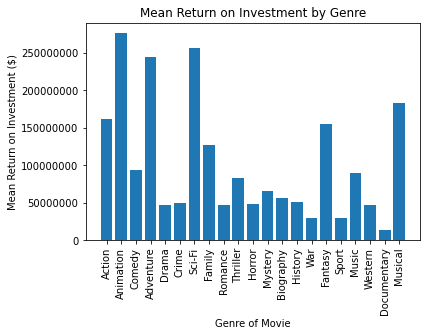

In [36]:
avg_profit, ax = plt.subplots()
ax.bar(x = list(genre_profits.keys()), height = list(genre_profits.values()));
ax.tick_params(axis='x', labelrotation = 90);
ax.ticklabel_format(axis='y',style='plain')
ax.set_ylabel('Mean Return on Investment ($)');
ax.set_xlabel('Genre of Movie');
ax.set_title('Mean Return on Investment by Genre');

In [37]:
# This code is courtesy of datavizpyr at the following URL: https://datavizpyr.com/add-dollar-sign-on-axis-ticks-in-matplotlib/#:~:text=Barplot%20with%20Matplotlib-,Add%20Dollar%20Sign%20to%20Axis%20Ticks%20in%20Matplotlib,the%20argument%20for%20formatting%20string.
# Currency function will help label axes appropriately when plotting monetary figures.
def currency(x, pos):
    """The two args are the value and tick position"""
    if x >= 1e6:
        s = '${:1.1f}M'.format(x*1e-6)
    elif x == 0:
        s = '${:1.1f}M'.format(x*1e-6)
    else:
        s = '${:1.0f}K'.format(x*1e-3)
    return s

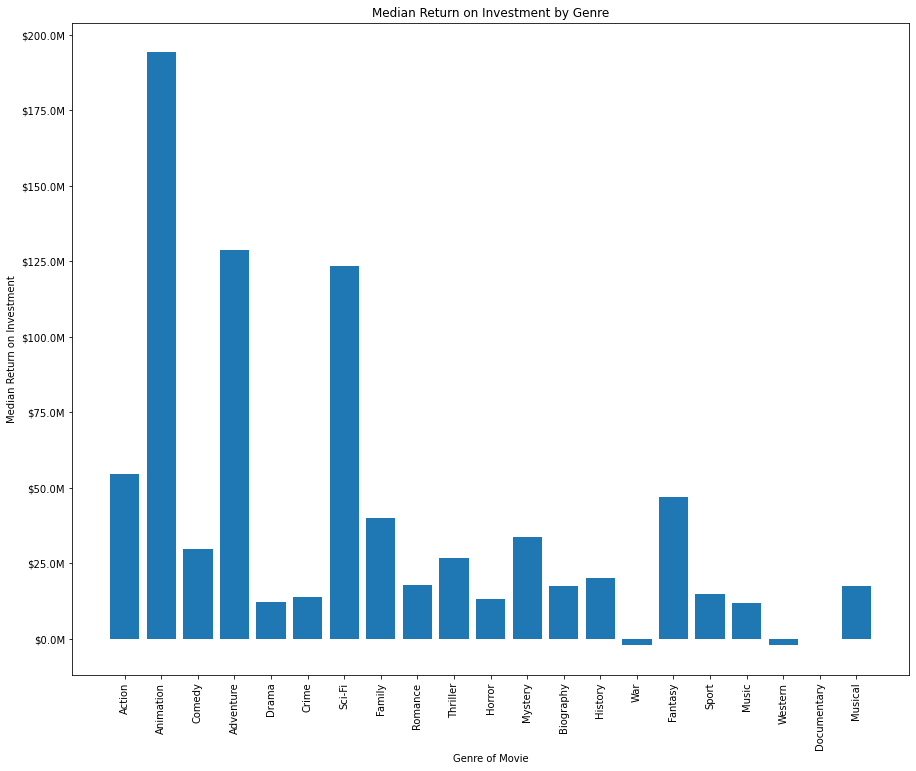

In [38]:
med_profit, ax = plt.subplots(figsize=(15,12))
ax.bar(x = list(genre_medians.keys()), height = list(genre_medians.values()));
ax.tick_params(axis='x', labelrotation = 90);
ax.ticklabel_format(axis='y',style='plain')
ax.set_ylabel('Median Return on Investment');
ax.set_xlabel('Genre of Movie');
ax.set_title('Median Return on Investment by Genre')
ax.yaxis.set_major_formatter(currency);

plt.savefig('./images/MedianROIbyReleaseMonth', dpi=500)

### Return on Investment by Release Month

In [42]:
# Calculate mean profit by release_month
df_profit_mean = df_budget.groupby('release_month')['return_on_investment'].mean()

In [43]:
df_profit_median = df_budget.groupby('release_month')['return_on_investment'].median()

In [44]:
df_budget.describe()

,production_budget,worldwide_gross,release_year,release_month,return_on_investment
count,5.698000e+03,5.698000e+03,5698.000000,5698.000000,5.698000e+03
mean,3.181423e+07,9.174801e+07,2004.211302,7.051773,5.993378e+07
std,4.197735e+07,1.754208e+08,12.292994,3.483801,1.466020e+08
min,1.100000e+03,0.000000e+00,1916.000000,1.000000,-2.002376e+08
25%,5.000000e+06,4.112890e+06,2000.000000,4.000000,-2.229934e+06
50%,1.700000e+07,2.792412e+07,2007.000000,7.000000,8.460828e+06
75%,4.000000e+07,9.808585e+07,2012.000000,10.000000,6.114558e+07
max,4.250000e+08,2.776345e+09,2020.000000,12.000000,2.351345e+09


Because the mean profit is significantly larger than the median profit, large outliars appear to skew the mean. For this reason, we will use the median profit for our analysis.


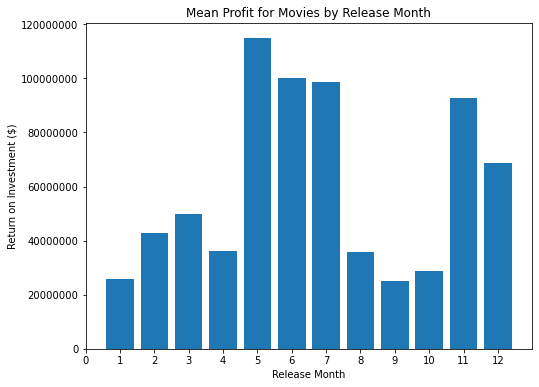

In [45]:
fig, ax = plt.subplots(figsize=(8,6))

ax.bar(x=list(df_profit_mean.index), height=list(df_profit_mean.values));
ax.set_ylabel('Return on Investment ($)');
ax.set_xlabel('Release Month');
ax.set_title('Mean Profit for Movies by Release Month');
ax.set_xticks(list(range(13)));
ax.ticklabel_format(axis='y',style='plain')

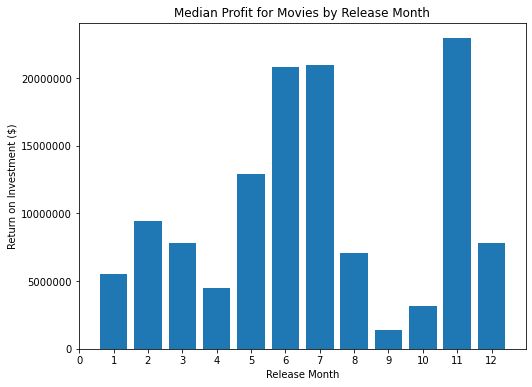

In [36]:
fig, ax = plt.subplots(figsize=(8,6))

ax.bar(x=list(df_profit_median.index), height=list(df_profit_median.values));
ax.set_ylabel('Return on Investment ($)');
ax.set_xlabel('Release Month');
ax.set_title('Median Profit for Movies by Release Month');
ax.set_xticks(list(range(13)));
ax.ticklabel_format(axis='y',style='plain')

### Revenue vs. Production Budget

## Conclusions


- **Movies in the animation, adventure and sci-fi genres tend to produce better return on investment than other genres.** As a result, we recommend prioritizing the creation of content that aligns with these genres. Avoid war and western-themed content as these tend to produce unfavorable ROI.
- **Movies released in June, July and November tend to generate better return on investment than other months.** As a result, we recommend targeting new releases for the summer or November months.
- **There is a strong correlation between movie production budget and return on investment.** Microsoft should direct its movie-making budget toward a relatively small number of projects in the above genres to avoid diluting ROI.


### Next Steps